In [1]:
from selenium import webdriver
from selenium.webdriver.edge.service import Service as EdgeService
from selenium.webdriver.edge.options import Options as EdgeOptions           # importing Libraries
from webdriver_manager.microsoft import EdgeChromiumDriverManager
from bs4 import BeautifulSoup
import pandas as pd
import numpy as np
import time

options = EdgeOptions()
options.add_argument("--start-maximized")
service = EdgeService(EdgeChromiumDriverManager().install())


locations = ["bangalore", "delhi", "mumbai", "hyderabad", "chennai","lucknow","kolkata","pune","jaipur","gurgaon","noida","delhi-ncr"]  # Add more cities here

all_cars = []

for city in locations:
    print(f"Scraping city: {city}...")
    url = f"https://www.spinny.com/used-cars-in-{city}/s/"

    driver = webdriver.Edge(service=service, options=options)
    driver.get(url)
    time.sleep(5)

    last_height = driver.execute_script("return document.body.scrollHeight")
    for _ in range(30):
        driver.execute_script("window.scrollTo(0, document.body.scrollHeight);")
        time.sleep(2)
        new_height = driver.execute_script("return document.body.scrollHeight")
        if new_height == last_height:
            break
        last_height = new_height

    soup = BeautifulSoup(driver.page_source, "html.parser")
    driver.quit()

    Car_Name, Price, KMS, Fuel, Transmission, Location,Emi = [], [], [], [], [], [], []

    cars = soup.find_all("div", class_="CarListingCardDetail__productDetailContainer")
    for car in cars:
        name = car.find("h3", class_="ListingBrandModelDetail__makeModelInfo ListingBrandModelDetail__medium")
        Car_Name.append(name.text.strip() if name else np.nan)

        price = car.find("li", class_="ListingPricingDetail__price ListingPricingDetail__medium")
        Price.append(price.text.strip() if price else np.nan)

        loc = car.find("span", class_="HubDetails__hubAddress")
        Location.append(loc.text.strip() if loc else city.title())  # Default to city if not found

        emi = car.find("li", class_="ListingPricingDetail__emi ListingPricingDetail__medium")
        Emi.append(emi.text.strip() if emi else np.nan)

    sections = soup.find_all("ul", class_="CarListingCardDetail__more")
    for sec in sections:
        li_tags = sec.find_all("li")
        if len(li_tags) >= 3:
            KMS.append(li_tags[0].text.strip())
            Fuel.append(li_tags[1].text.strip())
            Transmission.append(li_tags[2].text.strip())
        else:
            KMS.append(np.nan)
            Fuel.append(np.nan)
            Transmission.append(np.nan)

    min_len = min(len(Car_Name), len(Price), len(KMS), len(Fuel), len(Transmission), len(Location),len(Emi))
    df = pd.DataFrame({
        "City": [city.title()] * min_len,
        "Car_Name": Car_Name[:min_len],
        "Price": Price[:min_len],
        "KMS": KMS[:min_len],
        "Fuel": Fuel[:min_len],
        "Transmission": Transmission[:min_len],
        "Location": Location[:min_len],
        "Emi":Emi[:min_len]
    })

    all_cars.append(df)

# Combine all cities into one DataFrame
final_df = pd.concat(all_cars, ignore_index=True)

final_df


Scraping city: bangalore...
Scraping city: delhi...
Scraping city: mumbai...
Scraping city: hyderabad...
Scraping city: chennai...
Scraping city: lucknow...
Scraping city: kolkata...
Scraping city: pune...
Scraping city: jaipur...
Scraping city: gurgaon...
Scraping city: noida...
Scraping city: delhi-ncr...


,City,Car_Name,Price,KMS,Fuel,Transmission,Location,Emi
0,Bangalore,2019 Hyundai Grand i10Sportz 1.2 Kappa VTVT,5.54 Lakh,41.5K km,petrol,manual,"Spinny Car Hub, Nexus Shanti Niketan Mall - Wh...","EMI ₹9,434/m*"
1,Bangalore,2012 Maruti ErtigaVDi,4.27 Lakh,135.5K km,diesel,manual,"Spinny Car Hub, Mantri Mall, Bangalore","EMI ₹16,240/m*"
2,Bangalore,2016 Mahindra XUV500W10 AT,8.57 Lakh,133.5K km,diesel,automatic,"Spinny Car Hub, Nexus Shanti Niketan Mall - Wh...","EMI ₹15,316/m*"
3,Bangalore,2015 Hyundai Grand i10Asta 1.2 Kappa VTVT (O),4.59 Lakh,41.5K km,petrol,manual,"Spinny Car Hub, Nexus Shanti Niketan Mall - Wh...","EMI ₹8,354/m*"
4,Bangalore,2016 Hyundai Creta1.6 SX Plus Auto Petrol,9.26 Lakh,59K km,petrol,automatic,"Spinny Car Hub, Bangalore Vega Mall","EMI ₹15,769/m*"
...,...,...,...,...,...,...,...,...
4765,Delhi-Ncr,2018 Ford Figo AspireTitanium 1.2 Ti-VCT,3.81 Lakh,51K km,petrol,manual,"Spinny Park EDM, Ghaziabad","EMI ₹6,082/m*"
4766,Delhi-Ncr,2017 Honda WR-VVX MT Petrol,5.75 Lakh,47.5K km,petrol,manual,"Spinny Car Hub, Trillium Avenue, Gurgaon","EMI ₹9,791/m*"
4767,Delhi-Ncr,2020 Maruti SwiftZXI AMT,6.33 Lakh,48K km,petrol,automatic,"Spinny Car Hub, Faridabad","EMI ₹10,779/m*"
4768,Delhi-Ncr,2018 Hyundai Grand i10Sportz 1.2 Kappa VTVT CN...,4.37 Lakh,77K km,petrol+cng,manual,"Spinny Mini Car Hub,Sonipat","EMI ₹7,441/m*"


In [2]:
final_df.to_csv("Spinny_Cars_All_Locations.csv", index=False)


In [26]:
df=pd.read_csv("Spinny_Cars_All_Locations.csv")
df

,City,Car_Name,Price,KMS,Fuel,Transmission,Location,Emi
0,Bangalore,2019 Hyundai Grand i10Sportz 1.2 Kappa VTVT,5.54 Lakh,41.5K km,petrol,manual,"Spinny Car Hub, Nexus Shanti Niketan Mall - Wh...","EMI ₹9,434/m*"
1,Bangalore,2012 Maruti ErtigaVDi,4.27 Lakh,135.5K km,diesel,manual,"Spinny Car Hub, Mantri Mall, Bangalore","EMI ₹16,240/m*"
2,Bangalore,2016 Mahindra XUV500W10 AT,8.57 Lakh,133.5K km,diesel,automatic,"Spinny Car Hub, Nexus Shanti Niketan Mall - Wh...","EMI ₹15,316/m*"
3,Bangalore,2015 Hyundai Grand i10Asta 1.2 Kappa VTVT (O),4.59 Lakh,41.5K km,petrol,manual,"Spinny Car Hub, Nexus Shanti Niketan Mall - Wh...","EMI ₹8,354/m*"
4,Bangalore,2016 Hyundai Creta1.6 SX Plus Auto Petrol,9.26 Lakh,59K km,petrol,automatic,"Spinny Car Hub, Bangalore Vega Mall","EMI ₹15,769/m*"
...,...,...,...,...,...,...,...,...
4765,Delhi-Ncr,2018 Ford Figo AspireTitanium 1.2 Ti-VCT,3.81 Lakh,51K km,petrol,manual,"Spinny Park EDM, Ghaziabad","EMI ₹6,082/m*"
4766,Delhi-Ncr,2017 Honda WR-VVX MT Petrol,5.75 Lakh,47.5K km,petrol,manual,"Spinny Car Hub, Trillium Avenue, Gurgaon","EMI ₹9,791/m*"
4767,Delhi-Ncr,2020 Maruti SwiftZXI AMT,6.33 Lakh,48K km,petrol,automatic,"Spinny Car Hub, Faridabad","EMI ₹10,779/m*"
4768,Delhi-Ncr,2018 Hyundai Grand i10Sportz 1.2 Kappa VTVT CN...,4.37 Lakh,77K km,petrol+cng,manual,"Spinny Mini Car Hub,Sonipat","EMI ₹7,441/m*"


In [28]:
import pandas as pd
df=pd.read_csv("Spinny_Cars_All_Locations.csv")
df

,City,Car_Name,Price,KMS,Fuel,Transmission,Location,Emi
0,Bangalore,2019 Hyundai Grand i10Sportz 1.2 Kappa VTVT,5.54 Lakh,41.5K km,petrol,manual,"Spinny Car Hub, Nexus Shanti Niketan Mall - Wh...","EMI ₹9,434/m*"
1,Bangalore,2012 Maruti ErtigaVDi,4.27 Lakh,135.5K km,diesel,manual,"Spinny Car Hub, Mantri Mall, Bangalore","EMI ₹16,240/m*"
2,Bangalore,2016 Mahindra XUV500W10 AT,8.57 Lakh,133.5K km,diesel,automatic,"Spinny Car Hub, Nexus Shanti Niketan Mall - Wh...","EMI ₹15,316/m*"
3,Bangalore,2015 Hyundai Grand i10Asta 1.2 Kappa VTVT (O),4.59 Lakh,41.5K km,petrol,manual,"Spinny Car Hub, Nexus Shanti Niketan Mall - Wh...","EMI ₹8,354/m*"
4,Bangalore,2016 Hyundai Creta1.6 SX Plus Auto Petrol,9.26 Lakh,59K km,petrol,automatic,"Spinny Car Hub, Bangalore Vega Mall","EMI ₹15,769/m*"
...,...,...,...,...,...,...,...,...
4765,Delhi-Ncr,2018 Ford Figo AspireTitanium 1.2 Ti-VCT,3.81 Lakh,51K km,petrol,manual,"Spinny Park EDM, Ghaziabad","EMI ₹6,082/m*"
4766,Delhi-Ncr,2017 Honda WR-VVX MT Petrol,5.75 Lakh,47.5K km,petrol,manual,"Spinny Car Hub, Trillium Avenue, Gurgaon","EMI ₹9,791/m*"
4767,Delhi-Ncr,2020 Maruti SwiftZXI AMT,6.33 Lakh,48K km,petrol,automatic,"Spinny Car Hub, Faridabad","EMI ₹10,779/m*"
4768,Delhi-Ncr,2018 Hyundai Grand i10Sportz 1.2 Kappa VTVT CN...,4.37 Lakh,77K km,petrol+cng,manual,"Spinny Mini Car Hub,Sonipat","EMI ₹7,441/m*"


In [30]:
df['Year'] = df['Car_Name'].str.extract(r'^(\d{4})')
df

,City,Car_Name,Price,KMS,Fuel,Transmission,Location,Emi,Year
0,Bangalore,2019 Hyundai Grand i10Sportz 1.2 Kappa VTVT,5.54 Lakh,41.5K km,petrol,manual,"Spinny Car Hub, Nexus Shanti Niketan Mall - Wh...","EMI ₹9,434/m*",2019
1,Bangalore,2012 Maruti ErtigaVDi,4.27 Lakh,135.5K km,diesel,manual,"Spinny Car Hub, Mantri Mall, Bangalore","EMI ₹16,240/m*",2012
2,Bangalore,2016 Mahindra XUV500W10 AT,8.57 Lakh,133.5K km,diesel,automatic,"Spinny Car Hub, Nexus Shanti Niketan Mall - Wh...","EMI ₹15,316/m*",2016
3,Bangalore,2015 Hyundai Grand i10Asta 1.2 Kappa VTVT (O),4.59 Lakh,41.5K km,petrol,manual,"Spinny Car Hub, Nexus Shanti Niketan Mall - Wh...","EMI ₹8,354/m*",2015
4,Bangalore,2016 Hyundai Creta1.6 SX Plus Auto Petrol,9.26 Lakh,59K km,petrol,automatic,"Spinny Car Hub, Bangalore Vega Mall","EMI ₹15,769/m*",2016
...,...,...,...,...,...,...,...,...,...
4765,Delhi-Ncr,2018 Ford Figo AspireTitanium 1.2 Ti-VCT,3.81 Lakh,51K km,petrol,manual,"Spinny Park EDM, Ghaziabad","EMI ₹6,082/m*",2018
4766,Delhi-Ncr,2017 Honda WR-VVX MT Petrol,5.75 Lakh,47.5K km,petrol,manual,"Spinny Car Hub, Trillium Avenue, Gurgaon","EMI ₹9,791/m*",2017
4767,Delhi-Ncr,2020 Maruti SwiftZXI AMT,6.33 Lakh,48K km,petrol,automatic,"Spinny Car Hub, Faridabad","EMI ₹10,779/m*",2020
4768,Delhi-Ncr,2018 Hyundai Grand i10Sportz 1.2 Kappa VTVT CN...,4.37 Lakh,77K km,petrol+cng,manual,"Spinny Mini Car Hub,Sonipat","EMI ₹7,441/m*",2018


In [32]:
df['Car'] = df['Car_Name'].str.replace(r'^\d{4}\s+', '', regex=True)
df

,City,Car_Name,Price,KMS,Fuel,Transmission,Location,Emi,Year,Car
0,Bangalore,2019 Hyundai Grand i10Sportz 1.2 Kappa VTVT,5.54 Lakh,41.5K km,petrol,manual,"Spinny Car Hub, Nexus Shanti Niketan Mall - Wh...","EMI ₹9,434/m*",2019,Hyundai Grand i10Sportz 1.2 Kappa VTVT
1,Bangalore,2012 Maruti ErtigaVDi,4.27 Lakh,135.5K km,diesel,manual,"Spinny Car Hub, Mantri Mall, Bangalore","EMI ₹16,240/m*",2012,Maruti ErtigaVDi
2,Bangalore,2016 Mahindra XUV500W10 AT,8.57 Lakh,133.5K km,diesel,automatic,"Spinny Car Hub, Nexus Shanti Niketan Mall - Wh...","EMI ₹15,316/m*",2016,Mahindra XUV500W10 AT
3,Bangalore,2015 Hyundai Grand i10Asta 1.2 Kappa VTVT (O),4.59 Lakh,41.5K km,petrol,manual,"Spinny Car Hub, Nexus Shanti Niketan Mall - Wh...","EMI ₹8,354/m*",2015,Hyundai Grand i10Asta 1.2 Kappa VTVT (O)
4,Bangalore,2016 Hyundai Creta1.6 SX Plus Auto Petrol,9.26 Lakh,59K km,petrol,automatic,"Spinny Car Hub, Bangalore Vega Mall","EMI ₹15,769/m*",2016,Hyundai Creta1.6 SX Plus Auto Petrol
...,...,...,...,...,...,...,...,...,...,...
4765,Delhi-Ncr,2018 Ford Figo AspireTitanium 1.2 Ti-VCT,3.81 Lakh,51K km,petrol,manual,"Spinny Park EDM, Ghaziabad","EMI ₹6,082/m*",2018,Ford Figo AspireTitanium 1.2 Ti-VCT
4766,Delhi-Ncr,2017 Honda WR-VVX MT Petrol,5.75 Lakh,47.5K km,petrol,manual,"Spinny Car Hub, Trillium Avenue, Gurgaon","EMI ₹9,791/m*",2017,Honda WR-VVX MT Petrol
4767,Delhi-Ncr,2020 Maruti SwiftZXI AMT,6.33 Lakh,48K km,petrol,automatic,"Spinny Car Hub, Faridabad","EMI ₹10,779/m*",2020,Maruti SwiftZXI AMT
4768,Delhi-Ncr,2018 Hyundai Grand i10Sportz 1.2 Kappa VTVT CN...,4.37 Lakh,77K km,petrol+cng,manual,"Spinny Mini Car Hub,Sonipat","EMI ₹7,441/m*",2018,Hyundai Grand i10Sportz 1.2 Kappa VTVT CNG (Ou...


In [34]:
df = df.drop(columns=['Car_Name'])
df

,City,Price,KMS,Fuel,Transmission,Location,Emi,Year,Car
0,Bangalore,5.54 Lakh,41.5K km,petrol,manual,"Spinny Car Hub, Nexus Shanti Niketan Mall - Wh...","EMI ₹9,434/m*",2019,Hyundai Grand i10Sportz 1.2 Kappa VTVT
1,Bangalore,4.27 Lakh,135.5K km,diesel,manual,"Spinny Car Hub, Mantri Mall, Bangalore","EMI ₹16,240/m*",2012,Maruti ErtigaVDi
2,Bangalore,8.57 Lakh,133.5K km,diesel,automatic,"Spinny Car Hub, Nexus Shanti Niketan Mall - Wh...","EMI ₹15,316/m*",2016,Mahindra XUV500W10 AT
3,Bangalore,4.59 Lakh,41.5K km,petrol,manual,"Spinny Car Hub, Nexus Shanti Niketan Mall - Wh...","EMI ₹8,354/m*",2015,Hyundai Grand i10Asta 1.2 Kappa VTVT (O)
4,Bangalore,9.26 Lakh,59K km,petrol,automatic,"Spinny Car Hub, Bangalore Vega Mall","EMI ₹15,769/m*",2016,Hyundai Creta1.6 SX Plus Auto Petrol
...,...,...,...,...,...,...,...,...,...
4765,Delhi-Ncr,3.81 Lakh,51K km,petrol,manual,"Spinny Park EDM, Ghaziabad","EMI ₹6,082/m*",2018,Ford Figo AspireTitanium 1.2 Ti-VCT
4766,Delhi-Ncr,5.75 Lakh,47.5K km,petrol,manual,"Spinny Car Hub, Trillium Avenue, Gurgaon","EMI ₹9,791/m*",2017,Honda WR-VVX MT Petrol
4767,Delhi-Ncr,6.33 Lakh,48K km,petrol,automatic,"Spinny Car Hub, Faridabad","EMI ₹10,779/m*",2020,Maruti SwiftZXI AMT
4768,Delhi-Ncr,4.37 Lakh,77K km,petrol+cng,manual,"Spinny Mini Car Hub,Sonipat","EMI ₹7,441/m*",2018,Hyundai Grand i10Sportz 1.2 Kappa VTVT CNG (Ou...


In [36]:
df = df[['Car', 'Year', 'City','Location', 'KMS', 'Fuel', 'Transmission', 'Price','Emi']]
df

,Car,Year,City,Location,KMS,Fuel,Transmission,Price,Emi
0,Hyundai Grand i10Sportz 1.2 Kappa VTVT,2019,Bangalore,"Spinny Car Hub, Nexus Shanti Niketan Mall - Wh...",41.5K km,petrol,manual,5.54 Lakh,"EMI ₹9,434/m*"
1,Maruti ErtigaVDi,2012,Bangalore,"Spinny Car Hub, Mantri Mall, Bangalore",135.5K km,diesel,manual,4.27 Lakh,"EMI ₹16,240/m*"
2,Mahindra XUV500W10 AT,2016,Bangalore,"Spinny Car Hub, Nexus Shanti Niketan Mall - Wh...",133.5K km,diesel,automatic,8.57 Lakh,"EMI ₹15,316/m*"
3,Hyundai Grand i10Asta 1.2 Kappa VTVT (O),2015,Bangalore,"Spinny Car Hub, Nexus Shanti Niketan Mall - Wh...",41.5K km,petrol,manual,4.59 Lakh,"EMI ₹8,354/m*"
4,Hyundai Creta1.6 SX Plus Auto Petrol,2016,Bangalore,"Spinny Car Hub, Bangalore Vega Mall",59K km,petrol,automatic,9.26 Lakh,"EMI ₹15,769/m*"
...,...,...,...,...,...,...,...,...,...
4765,Ford Figo AspireTitanium 1.2 Ti-VCT,2018,Delhi-Ncr,"Spinny Park EDM, Ghaziabad",51K km,petrol,manual,3.81 Lakh,"EMI ₹6,082/m*"
4766,Honda WR-VVX MT Petrol,2017,Delhi-Ncr,"Spinny Car Hub, Trillium Avenue, Gurgaon",47.5K km,petrol,manual,5.75 Lakh,"EMI ₹9,791/m*"
4767,Maruti SwiftZXI AMT,2020,Delhi-Ncr,"Spinny Car Hub, Faridabad",48K km,petrol,automatic,6.33 Lakh,"EMI ₹10,779/m*"
4768,Hyundai Grand i10Sportz 1.2 Kappa VTVT CNG (Ou...,2018,Delhi-Ncr,"Spinny Mini Car Hub,Sonipat",77K km,petrol+cng,manual,4.37 Lakh,"EMI ₹7,441/m*"


In [38]:
df = df.drop(columns=['Location'])
df

,Car,Year,City,KMS,Fuel,Transmission,Price,Emi
0,Hyundai Grand i10Sportz 1.2 Kappa VTVT,2019,Bangalore,41.5K km,petrol,manual,5.54 Lakh,"EMI ₹9,434/m*"
1,Maruti ErtigaVDi,2012,Bangalore,135.5K km,diesel,manual,4.27 Lakh,"EMI ₹16,240/m*"
2,Mahindra XUV500W10 AT,2016,Bangalore,133.5K km,diesel,automatic,8.57 Lakh,"EMI ₹15,316/m*"
3,Hyundai Grand i10Asta 1.2 Kappa VTVT (O),2015,Bangalore,41.5K km,petrol,manual,4.59 Lakh,"EMI ₹8,354/m*"
4,Hyundai Creta1.6 SX Plus Auto Petrol,2016,Bangalore,59K km,petrol,automatic,9.26 Lakh,"EMI ₹15,769/m*"
...,...,...,...,...,...,...,...,...
4765,Ford Figo AspireTitanium 1.2 Ti-VCT,2018,Delhi-Ncr,51K km,petrol,manual,3.81 Lakh,"EMI ₹6,082/m*"
4766,Honda WR-VVX MT Petrol,2017,Delhi-Ncr,47.5K km,petrol,manual,5.75 Lakh,"EMI ₹9,791/m*"
4767,Maruti SwiftZXI AMT,2020,Delhi-Ncr,48K km,petrol,automatic,6.33 Lakh,"EMI ₹10,779/m*"
4768,Hyundai Grand i10Sportz 1.2 Kappa VTVT CNG (Ou...,2018,Delhi-Ncr,77K km,petrol+cng,manual,4.37 Lakh,"EMI ₹7,441/m*"


In [40]:
df['Brand'] = df['Car'].str.extract(r'^(\w+)')
df

,Car,Year,City,KMS,Fuel,Transmission,Price,Emi,Brand
0,Hyundai Grand i10Sportz 1.2 Kappa VTVT,2019,Bangalore,41.5K km,petrol,manual,5.54 Lakh,"EMI ₹9,434/m*",Hyundai
1,Maruti ErtigaVDi,2012,Bangalore,135.5K km,diesel,manual,4.27 Lakh,"EMI ₹16,240/m*",Maruti
2,Mahindra XUV500W10 AT,2016,Bangalore,133.5K km,diesel,automatic,8.57 Lakh,"EMI ₹15,316/m*",Mahindra
3,Hyundai Grand i10Asta 1.2 Kappa VTVT (O),2015,Bangalore,41.5K km,petrol,manual,4.59 Lakh,"EMI ₹8,354/m*",Hyundai
4,Hyundai Creta1.6 SX Plus Auto Petrol,2016,Bangalore,59K km,petrol,automatic,9.26 Lakh,"EMI ₹15,769/m*",Hyundai
...,...,...,...,...,...,...,...,...,...
4765,Ford Figo AspireTitanium 1.2 Ti-VCT,2018,Delhi-Ncr,51K km,petrol,manual,3.81 Lakh,"EMI ₹6,082/m*",Ford
4766,Honda WR-VVX MT Petrol,2017,Delhi-Ncr,47.5K km,petrol,manual,5.75 Lakh,"EMI ₹9,791/m*",Honda
4767,Maruti SwiftZXI AMT,2020,Delhi-Ncr,48K km,petrol,automatic,6.33 Lakh,"EMI ₹10,779/m*",Maruti
4768,Hyundai Grand i10Sportz 1.2 Kappa VTVT CNG (Ou...,2018,Delhi-Ncr,77K km,petrol+cng,manual,4.37 Lakh,"EMI ₹7,441/m*",Hyundai


In [42]:
df = df[['Brand', 'Car', 'Year','City', 'KMS', 'Fuel', 'Transmission', 'Price','Emi']]
df

,Brand,Car,Year,City,KMS,Fuel,Transmission,Price,Emi
0,Hyundai,Hyundai Grand i10Sportz 1.2 Kappa VTVT,2019,Bangalore,41.5K km,petrol,manual,5.54 Lakh,"EMI ₹9,434/m*"
1,Maruti,Maruti ErtigaVDi,2012,Bangalore,135.5K km,diesel,manual,4.27 Lakh,"EMI ₹16,240/m*"
2,Mahindra,Mahindra XUV500W10 AT,2016,Bangalore,133.5K km,diesel,automatic,8.57 Lakh,"EMI ₹15,316/m*"
3,Hyundai,Hyundai Grand i10Asta 1.2 Kappa VTVT (O),2015,Bangalore,41.5K km,petrol,manual,4.59 Lakh,"EMI ₹8,354/m*"
4,Hyundai,Hyundai Creta1.6 SX Plus Auto Petrol,2016,Bangalore,59K km,petrol,automatic,9.26 Lakh,"EMI ₹15,769/m*"
...,...,...,...,...,...,...,...,...,...
4765,Ford,Ford Figo AspireTitanium 1.2 Ti-VCT,2018,Delhi-Ncr,51K km,petrol,manual,3.81 Lakh,"EMI ₹6,082/m*"
4766,Honda,Honda WR-VVX MT Petrol,2017,Delhi-Ncr,47.5K km,petrol,manual,5.75 Lakh,"EMI ₹9,791/m*"
4767,Maruti,Maruti SwiftZXI AMT,2020,Delhi-Ncr,48K km,petrol,automatic,6.33 Lakh,"EMI ₹10,779/m*"
4768,Hyundai,Hyundai Grand i10Sportz 1.2 Kappa VTVT CNG (Ou...,2018,Delhi-Ncr,77K km,petrol+cng,manual,4.37 Lakh,"EMI ₹7,441/m*"


In [44]:
df['Car'] = df['Car'].str.replace(r'^\w+\s+', '', regex=True)
df

,Brand,Car,Year,City,KMS,Fuel,Transmission,Price,Emi
0,Hyundai,Grand i10Sportz 1.2 Kappa VTVT,2019,Bangalore,41.5K km,petrol,manual,5.54 Lakh,"EMI ₹9,434/m*"
1,Maruti,ErtigaVDi,2012,Bangalore,135.5K km,diesel,manual,4.27 Lakh,"EMI ₹16,240/m*"
2,Mahindra,XUV500W10 AT,2016,Bangalore,133.5K km,diesel,automatic,8.57 Lakh,"EMI ₹15,316/m*"
3,Hyundai,Grand i10Asta 1.2 Kappa VTVT (O),2015,Bangalore,41.5K km,petrol,manual,4.59 Lakh,"EMI ₹8,354/m*"
4,Hyundai,Creta1.6 SX Plus Auto Petrol,2016,Bangalore,59K km,petrol,automatic,9.26 Lakh,"EMI ₹15,769/m*"
...,...,...,...,...,...,...,...,...,...
4765,Ford,Figo AspireTitanium 1.2 Ti-VCT,2018,Delhi-Ncr,51K km,petrol,manual,3.81 Lakh,"EMI ₹6,082/m*"
4766,Honda,WR-VVX MT Petrol,2017,Delhi-Ncr,47.5K km,petrol,manual,5.75 Lakh,"EMI ₹9,791/m*"
4767,Maruti,SwiftZXI AMT,2020,Delhi-Ncr,48K km,petrol,automatic,6.33 Lakh,"EMI ₹10,779/m*"
4768,Hyundai,Grand i10Sportz 1.2 Kappa VTVT CNG (Outside Fi...,2018,Delhi-Ncr,77K km,petrol+cng,manual,4.37 Lakh,"EMI ₹7,441/m*"


In [46]:
df['KMS'] = df['KMS'].str.replace('km', '', regex=False).str.strip()
df


,Brand,Car,Year,City,KMS,Fuel,Transmission,Price,Emi
0,Hyundai,Grand i10Sportz 1.2 Kappa VTVT,2019,Bangalore,41.5K,petrol,manual,5.54 Lakh,"EMI ₹9,434/m*"
1,Maruti,ErtigaVDi,2012,Bangalore,135.5K,diesel,manual,4.27 Lakh,"EMI ₹16,240/m*"
2,Mahindra,XUV500W10 AT,2016,Bangalore,133.5K,diesel,automatic,8.57 Lakh,"EMI ₹15,316/m*"
3,Hyundai,Grand i10Asta 1.2 Kappa VTVT (O),2015,Bangalore,41.5K,petrol,manual,4.59 Lakh,"EMI ₹8,354/m*"
4,Hyundai,Creta1.6 SX Plus Auto Petrol,2016,Bangalore,59K,petrol,automatic,9.26 Lakh,"EMI ₹15,769/m*"
...,...,...,...,...,...,...,...,...,...
4765,Ford,Figo AspireTitanium 1.2 Ti-VCT,2018,Delhi-Ncr,51K,petrol,manual,3.81 Lakh,"EMI ₹6,082/m*"
4766,Honda,WR-VVX MT Petrol,2017,Delhi-Ncr,47.5K,petrol,manual,5.75 Lakh,"EMI ₹9,791/m*"
4767,Maruti,SwiftZXI AMT,2020,Delhi-Ncr,48K,petrol,automatic,6.33 Lakh,"EMI ₹10,779/m*"
4768,Hyundai,Grand i10Sportz 1.2 Kappa VTVT CNG (Outside Fi...,2018,Delhi-Ncr,77K,petrol+cng,manual,4.37 Lakh,"EMI ₹7,441/m*"


In [48]:
df['KMS'] = df['KMS'].apply(lambda x: float(x.replace('K', '')) * 1000 if 'K' in x else float(x))
df

,Brand,Car,Year,City,KMS,Fuel,Transmission,Price,Emi
0,Hyundai,Grand i10Sportz 1.2 Kappa VTVT,2019,Bangalore,41500.0,petrol,manual,5.54 Lakh,"EMI ₹9,434/m*"
1,Maruti,ErtigaVDi,2012,Bangalore,135500.0,diesel,manual,4.27 Lakh,"EMI ₹16,240/m*"
2,Mahindra,XUV500W10 AT,2016,Bangalore,133500.0,diesel,automatic,8.57 Lakh,"EMI ₹15,316/m*"
3,Hyundai,Grand i10Asta 1.2 Kappa VTVT (O),2015,Bangalore,41500.0,petrol,manual,4.59 Lakh,"EMI ₹8,354/m*"
4,Hyundai,Creta1.6 SX Plus Auto Petrol,2016,Bangalore,59000.0,petrol,automatic,9.26 Lakh,"EMI ₹15,769/m*"
...,...,...,...,...,...,...,...,...,...
4765,Ford,Figo AspireTitanium 1.2 Ti-VCT,2018,Delhi-Ncr,51000.0,petrol,manual,3.81 Lakh,"EMI ₹6,082/m*"
4766,Honda,WR-VVX MT Petrol,2017,Delhi-Ncr,47500.0,petrol,manual,5.75 Lakh,"EMI ₹9,791/m*"
4767,Maruti,SwiftZXI AMT,2020,Delhi-Ncr,48000.0,petrol,automatic,6.33 Lakh,"EMI ₹10,779/m*"
4768,Hyundai,Grand i10Sportz 1.2 Kappa VTVT CNG (Outside Fi...,2018,Delhi-Ncr,77000.0,petrol+cng,manual,4.37 Lakh,"EMI ₹7,441/m*"


In [50]:
# Convert to integer
df['KMS'] = df['KMS'].astype(int)
df

,Brand,Car,Year,City,KMS,Fuel,Transmission,Price,Emi
0,Hyundai,Grand i10Sportz 1.2 Kappa VTVT,2019,Bangalore,41500,petrol,manual,5.54 Lakh,"EMI ₹9,434/m*"
1,Maruti,ErtigaVDi,2012,Bangalore,135500,diesel,manual,4.27 Lakh,"EMI ₹16,240/m*"
2,Mahindra,XUV500W10 AT,2016,Bangalore,133500,diesel,automatic,8.57 Lakh,"EMI ₹15,316/m*"
3,Hyundai,Grand i10Asta 1.2 Kappa VTVT (O),2015,Bangalore,41500,petrol,manual,4.59 Lakh,"EMI ₹8,354/m*"
4,Hyundai,Creta1.6 SX Plus Auto Petrol,2016,Bangalore,59000,petrol,automatic,9.26 Lakh,"EMI ₹15,769/m*"
...,...,...,...,...,...,...,...,...,...
4765,Ford,Figo AspireTitanium 1.2 Ti-VCT,2018,Delhi-Ncr,51000,petrol,manual,3.81 Lakh,"EMI ₹6,082/m*"
4766,Honda,WR-VVX MT Petrol,2017,Delhi-Ncr,47500,petrol,manual,5.75 Lakh,"EMI ₹9,791/m*"
4767,Maruti,SwiftZXI AMT,2020,Delhi-Ncr,48000,petrol,automatic,6.33 Lakh,"EMI ₹10,779/m*"
4768,Hyundai,Grand i10Sportz 1.2 Kappa VTVT CNG (Outside Fi...,2018,Delhi-Ncr,77000,petrol+cng,manual,4.37 Lakh,"EMI ₹7,441/m*"


In [52]:
# Step 1: Convert to string first to avoid AttributeError
df['Price'] = df['Price'].astype(str)
df

,Brand,Car,Year,City,KMS,Fuel,Transmission,Price,Emi
0,Hyundai,Grand i10Sportz 1.2 Kappa VTVT,2019,Bangalore,41500,petrol,manual,5.54 Lakh,"EMI ₹9,434/m*"
1,Maruti,ErtigaVDi,2012,Bangalore,135500,diesel,manual,4.27 Lakh,"EMI ₹16,240/m*"
2,Mahindra,XUV500W10 AT,2016,Bangalore,133500,diesel,automatic,8.57 Lakh,"EMI ₹15,316/m*"
3,Hyundai,Grand i10Asta 1.2 Kappa VTVT (O),2015,Bangalore,41500,petrol,manual,4.59 Lakh,"EMI ₹8,354/m*"
4,Hyundai,Creta1.6 SX Plus Auto Petrol,2016,Bangalore,59000,petrol,automatic,9.26 Lakh,"EMI ₹15,769/m*"
...,...,...,...,...,...,...,...,...,...
4765,Ford,Figo AspireTitanium 1.2 Ti-VCT,2018,Delhi-Ncr,51000,petrol,manual,3.81 Lakh,"EMI ₹6,082/m*"
4766,Honda,WR-VVX MT Petrol,2017,Delhi-Ncr,47500,petrol,manual,5.75 Lakh,"EMI ₹9,791/m*"
4767,Maruti,SwiftZXI AMT,2020,Delhi-Ncr,48000,petrol,automatic,6.33 Lakh,"EMI ₹10,779/m*"
4768,Hyundai,Grand i10Sportz 1.2 Kappa VTVT CNG (Outside Fi...,2018,Delhi-Ncr,77000,petrol+cng,manual,4.37 Lakh,"EMI ₹7,441/m*"


In [54]:
# Step 2: Remove 'Lakh', strip whitespace, convert to float
df['Price'] = df['Price'].str.replace('Lakh', '', regex=False).str.strip().astype(float)
df

,Brand,Car,Year,City,KMS,Fuel,Transmission,Price,Emi
0,Hyundai,Grand i10Sportz 1.2 Kappa VTVT,2019,Bangalore,41500,petrol,manual,5.54,"EMI ₹9,434/m*"
1,Maruti,ErtigaVDi,2012,Bangalore,135500,diesel,manual,4.27,"EMI ₹16,240/m*"
2,Mahindra,XUV500W10 AT,2016,Bangalore,133500,diesel,automatic,8.57,"EMI ₹15,316/m*"
3,Hyundai,Grand i10Asta 1.2 Kappa VTVT (O),2015,Bangalore,41500,petrol,manual,4.59,"EMI ₹8,354/m*"
4,Hyundai,Creta1.6 SX Plus Auto Petrol,2016,Bangalore,59000,petrol,automatic,9.26,"EMI ₹15,769/m*"
...,...,...,...,...,...,...,...,...,...
4765,Ford,Figo AspireTitanium 1.2 Ti-VCT,2018,Delhi-Ncr,51000,petrol,manual,3.81,"EMI ₹6,082/m*"
4766,Honda,WR-VVX MT Petrol,2017,Delhi-Ncr,47500,petrol,manual,5.75,"EMI ₹9,791/m*"
4767,Maruti,SwiftZXI AMT,2020,Delhi-Ncr,48000,petrol,automatic,6.33,"EMI ₹10,779/m*"
4768,Hyundai,Grand i10Sportz 1.2 Kappa VTVT CNG (Outside Fi...,2018,Delhi-Ncr,77000,petrol+cng,manual,4.37,"EMI ₹7,441/m*"


In [56]:
# Step 3: Convert from Lakhs to actual amount
df['Price'] = (df['Price'] * 100000).astype(int)
df

,Brand,Car,Year,City,KMS,Fuel,Transmission,Price,Emi
0,Hyundai,Grand i10Sportz 1.2 Kappa VTVT,2019,Bangalore,41500,petrol,manual,554000,"EMI ₹9,434/m*"
1,Maruti,ErtigaVDi,2012,Bangalore,135500,diesel,manual,426999,"EMI ₹16,240/m*"
2,Mahindra,XUV500W10 AT,2016,Bangalore,133500,diesel,automatic,857000,"EMI ₹15,316/m*"
3,Hyundai,Grand i10Asta 1.2 Kappa VTVT (O),2015,Bangalore,41500,petrol,manual,459000,"EMI ₹8,354/m*"
4,Hyundai,Creta1.6 SX Plus Auto Petrol,2016,Bangalore,59000,petrol,automatic,926000,"EMI ₹15,769/m*"
...,...,...,...,...,...,...,...,...,...
4765,Ford,Figo AspireTitanium 1.2 Ti-VCT,2018,Delhi-Ncr,51000,petrol,manual,381000,"EMI ₹6,082/m*"
4766,Honda,WR-VVX MT Petrol,2017,Delhi-Ncr,47500,petrol,manual,575000,"EMI ₹9,791/m*"
4767,Maruti,SwiftZXI AMT,2020,Delhi-Ncr,48000,petrol,automatic,633000,"EMI ₹10,779/m*"
4768,Hyundai,Grand i10Sportz 1.2 Kappa VTVT CNG (Outside Fi...,2018,Delhi-Ncr,77000,petrol+cng,manual,437000,"EMI ₹7,441/m*"


In [58]:
df['Emi'] = df['Emi'].str.extract(r'₹([\d,]+)')
df['Emi'] = pd.to_numeric(df['Emi'].str.replace(',', ''), errors='coerce')
  # Remove commas and convert to int

In [60]:
df

,Brand,Car,Year,City,KMS,Fuel,Transmission,Price,Emi
0,Hyundai,Grand i10Sportz 1.2 Kappa VTVT,2019,Bangalore,41500,petrol,manual,554000,9434.0
1,Maruti,ErtigaVDi,2012,Bangalore,135500,diesel,manual,426999,16240.0
2,Mahindra,XUV500W10 AT,2016,Bangalore,133500,diesel,automatic,857000,15316.0
3,Hyundai,Grand i10Asta 1.2 Kappa VTVT (O),2015,Bangalore,41500,petrol,manual,459000,8354.0
4,Hyundai,Creta1.6 SX Plus Auto Petrol,2016,Bangalore,59000,petrol,automatic,926000,15769.0
...,...,...,...,...,...,...,...,...,...
4765,Ford,Figo AspireTitanium 1.2 Ti-VCT,2018,Delhi-Ncr,51000,petrol,manual,381000,6082.0
4766,Honda,WR-VVX MT Petrol,2017,Delhi-Ncr,47500,petrol,manual,575000,9791.0
4767,Maruti,SwiftZXI AMT,2020,Delhi-Ncr,48000,petrol,automatic,633000,10779.0
4768,Hyundai,Grand i10Sportz 1.2 Kappa VTVT CNG (Outside Fi...,2018,Delhi-Ncr,77000,petrol+cng,manual,437000,7441.0


In [62]:
df.to_csv("Used cars banglore.csv" ,index=False)

In [64]:
df=pd.read_csv("Used cars banglore.csv")
df

,Brand,Car,Year,City,KMS,Fuel,Transmission,Price,Emi
0,Hyundai,Grand i10Sportz 1.2 Kappa VTVT,2019,Bangalore,41500,petrol,manual,554000,9434.0
1,Maruti,ErtigaVDi,2012,Bangalore,135500,diesel,manual,426999,16240.0
2,Mahindra,XUV500W10 AT,2016,Bangalore,133500,diesel,automatic,857000,15316.0
3,Hyundai,Grand i10Asta 1.2 Kappa VTVT (O),2015,Bangalore,41500,petrol,manual,459000,8354.0
4,Hyundai,Creta1.6 SX Plus Auto Petrol,2016,Bangalore,59000,petrol,automatic,926000,15769.0
...,...,...,...,...,...,...,...,...,...
4765,Ford,Figo AspireTitanium 1.2 Ti-VCT,2018,Delhi-Ncr,51000,petrol,manual,381000,6082.0
4766,Honda,WR-VVX MT Petrol,2017,Delhi-Ncr,47500,petrol,manual,575000,9791.0
4767,Maruti,SwiftZXI AMT,2020,Delhi-Ncr,48000,petrol,automatic,633000,10779.0
4768,Hyundai,Grand i10Sportz 1.2 Kappa VTVT CNG (Outside Fi...,2018,Delhi-Ncr,77000,petrol+cng,manual,437000,7441.0


In [66]:
df.duplicated().sum()

21

In [68]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4770 entries, 0 to 4769
Data columns (total 9 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Brand         4770 non-null   object 
 1   Car           4770 non-null   object 
 2   Year          4770 non-null   int64  
 3   City          4770 non-null   object 
 4   KMS           4770 non-null   int64  
 5   Fuel          4770 non-null   object 
 6   Transmission  4770 non-null   object 
 7   Price         4770 non-null   int64  
 8   Emi           4751 non-null   float64
dtypes: float64(1), int64(3), object(5)
memory usage: 335.5+ KB


In [70]:
df = df.dropna(subset=['Emi'])
# Optional: convert to int if you want whole numbers
df['Emi'] = df['Emi'].astype(int)
df

C:\Users\User\AppData\Local\Temp\ipykernel_11408\1343967760.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Emi'] = df['Emi'].astype(int)


,Brand,Car,Year,City,KMS,Fuel,Transmission,Price,Emi
0,Hyundai,Grand i10Sportz 1.2 Kappa VTVT,2019,Bangalore,41500,petrol,manual,554000,9434
1,Maruti,ErtigaVDi,2012,Bangalore,135500,diesel,manual,426999,16240
2,Mahindra,XUV500W10 AT,2016,Bangalore,133500,diesel,automatic,857000,15316
3,Hyundai,Grand i10Asta 1.2 Kappa VTVT (O),2015,Bangalore,41500,petrol,manual,459000,8354
4,Hyundai,Creta1.6 SX Plus Auto Petrol,2016,Bangalore,59000,petrol,automatic,926000,15769
...,...,...,...,...,...,...,...,...,...
4765,Ford,Figo AspireTitanium 1.2 Ti-VCT,2018,Delhi-Ncr,51000,petrol,manual,381000,6082
4766,Honda,WR-VVX MT Petrol,2017,Delhi-Ncr,47500,petrol,manual,575000,9791
4767,Maruti,SwiftZXI AMT,2020,Delhi-Ncr,48000,petrol,automatic,633000,10779
4768,Hyundai,Grand i10Sportz 1.2 Kappa VTVT CNG (Outside Fi...,2018,Delhi-Ncr,77000,petrol+cng,manual,437000,7441


In [72]:
df.drop_duplicates(inplace=True)
df

C:\Users\User\AppData\Local\Temp\ipykernel_11408\1725291922.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.drop_duplicates(inplace=True)


,Brand,Car,Year,City,KMS,Fuel,Transmission,Price,Emi
0,Hyundai,Grand i10Sportz 1.2 Kappa VTVT,2019,Bangalore,41500,petrol,manual,554000,9434
1,Maruti,ErtigaVDi,2012,Bangalore,135500,diesel,manual,426999,16240
2,Mahindra,XUV500W10 AT,2016,Bangalore,133500,diesel,automatic,857000,15316
3,Hyundai,Grand i10Asta 1.2 Kappa VTVT (O),2015,Bangalore,41500,petrol,manual,459000,8354
4,Hyundai,Creta1.6 SX Plus Auto Petrol,2016,Bangalore,59000,petrol,automatic,926000,15769
...,...,...,...,...,...,...,...,...,...
4765,Ford,Figo AspireTitanium 1.2 Ti-VCT,2018,Delhi-Ncr,51000,petrol,manual,381000,6082
4766,Honda,WR-VVX MT Petrol,2017,Delhi-Ncr,47500,petrol,manual,575000,9791
4767,Maruti,SwiftZXI AMT,2020,Delhi-Ncr,48000,petrol,automatic,633000,10779
4768,Hyundai,Grand i10Sportz 1.2 Kappa VTVT CNG (Outside Fi...,2018,Delhi-Ncr,77000,petrol+cng,manual,437000,7441


In [74]:
df = df.reset_index(drop=True)
df

,Brand,Car,Year,City,KMS,Fuel,Transmission,Price,Emi
0,Hyundai,Grand i10Sportz 1.2 Kappa VTVT,2019,Bangalore,41500,petrol,manual,554000,9434
1,Maruti,ErtigaVDi,2012,Bangalore,135500,diesel,manual,426999,16240
2,Mahindra,XUV500W10 AT,2016,Bangalore,133500,diesel,automatic,857000,15316
3,Hyundai,Grand i10Asta 1.2 Kappa VTVT (O),2015,Bangalore,41500,petrol,manual,459000,8354
4,Hyundai,Creta1.6 SX Plus Auto Petrol,2016,Bangalore,59000,petrol,automatic,926000,15769
...,...,...,...,...,...,...,...,...,...
4725,Ford,Figo AspireTitanium 1.2 Ti-VCT,2018,Delhi-Ncr,51000,petrol,manual,381000,6082
4726,Honda,WR-VVX MT Petrol,2017,Delhi-Ncr,47500,petrol,manual,575000,9791
4727,Maruti,SwiftZXI AMT,2020,Delhi-Ncr,48000,petrol,automatic,633000,10779
4728,Hyundai,Grand i10Sportz 1.2 Kappa VTVT CNG (Outside Fi...,2018,Delhi-Ncr,77000,petrol+cng,manual,437000,7441


In [76]:
import matplotlib.pyplot as plt
import seaborn as sns


C:\Users\User\AppData\Local\Temp\ipykernel_11408\2402197424.py:5: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  y=k.set_xticklabels(k.get_xticklabels(), rotation=40, ha="right")


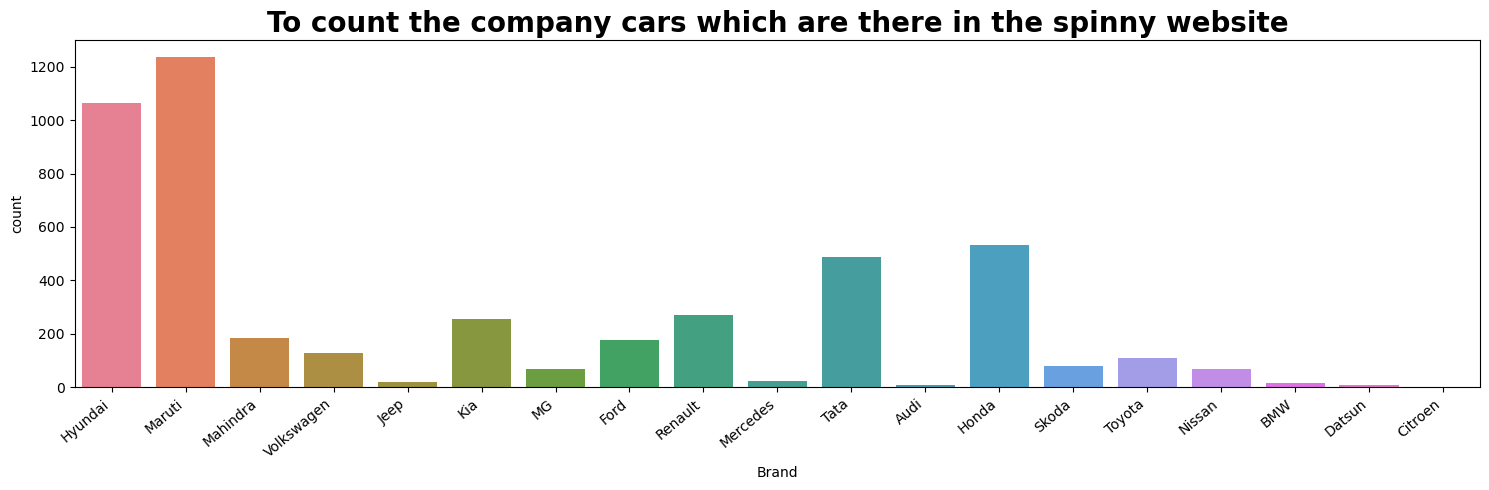

In [77]:
fig=plt.figure(figsize=(15,5))

k=sns.countplot(x='Brand',hue='Brand',data=df, palette='husl',legend=False)

y=k.set_xticklabels(k.get_xticklabels(), rotation=40, ha="right")
#ax.set_xticklabels(ax.get_xticklabels(), fontsize=7)
y=plt.title("To count the company cars which are there in the spinny website",fontsize=20,fontweight="bold")
plt.tight_layout()
plt.show(y)

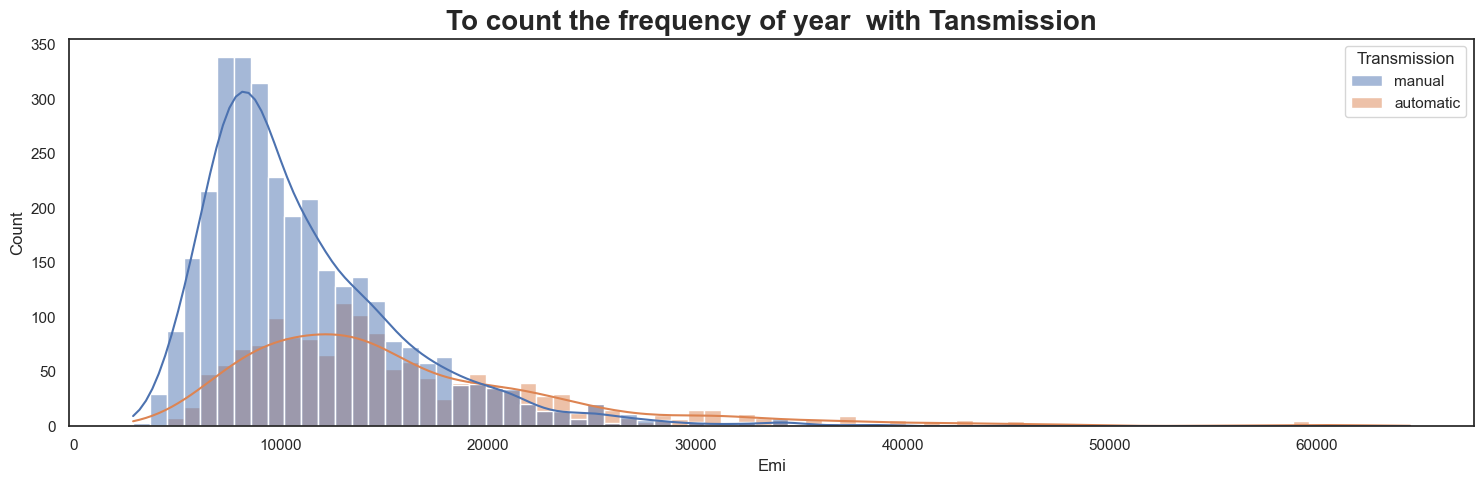

In [80]:
fig=plt.figure(figsize=(15,5))


fig=sns.set(style="white")

fig=sns.histplot(data=df, x="Emi", kde=True,color='green',hue='Transmission')
fig=fig.set_title("To count the frequency of year  with Tansmission",fontsize=20,fontweight="bold")
fig=plt.tight_layout()
plt.show(fig)

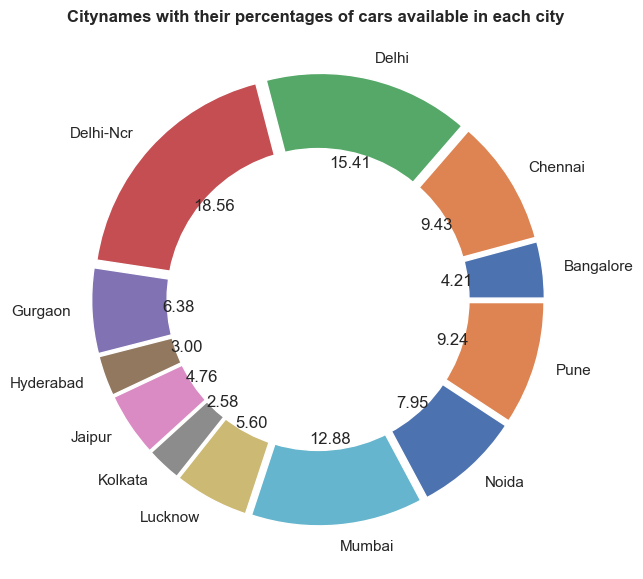

In [82]:
k=plt.figure(figsize=(10,7))

explode = (0.05, 0.05, 0.05, 0.05, 0.05,0.05,0.05,0.05,0.05,0.05,0.05,0.05)

k=df.groupby('City').size().plot(kind='pie', autopct='%.2f',explode=explode)
#k=plt.pie(cars24['Cityname'].value_counts(),labels=cars24['Cityname'])

centre_circle = plt.Circle((0, 0), 0.70, fc='white')
k=fig = plt.gcf()
k=fig.gca().add_artist(centre_circle)
#fig=fig.set_title("Citynames with their percentages",fontsize=20,fontweight="bold")
k=plt.title("Citynames with their percentages of cars available in each city ",fontsize=12,fontweight="bold")
plt.show(k)

C:\Users\User\AppData\Local\Temp\ipykernel_11408\3235859821.py:4: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  y=k.set_xticklabels(k.get_xticklabels(), rotation=40, ha="right")


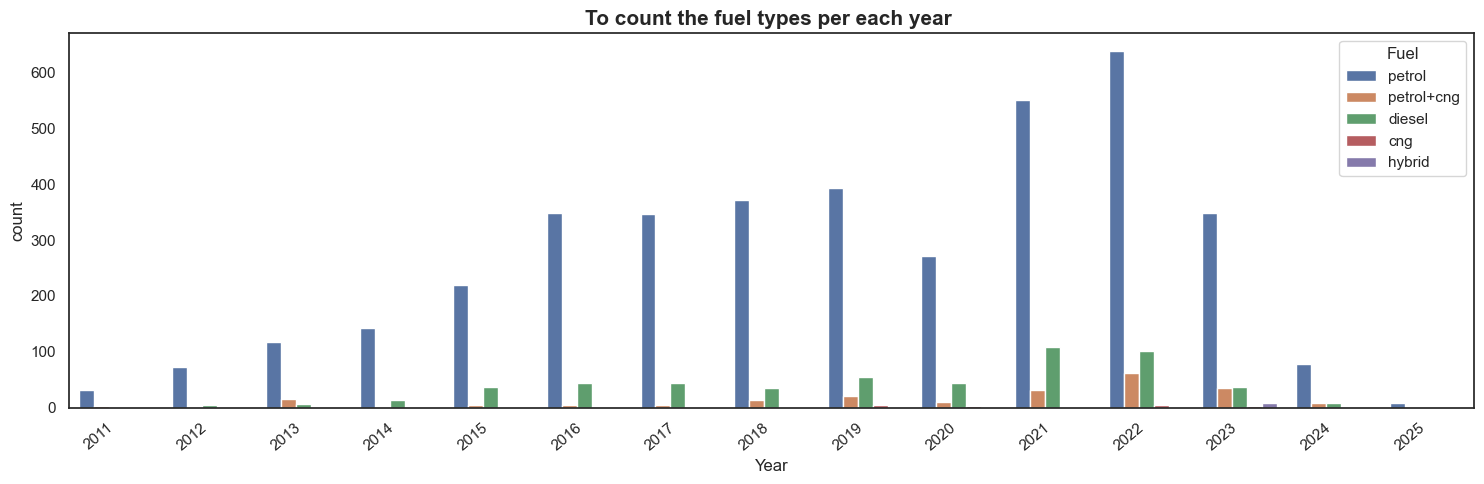

In [84]:
fig=plt.figure(figsize=(15,5))

k=sns.countplot(x='Year',data=df,hue="Fuel");
y=k.set_xticklabels(k.get_xticklabels(), rotation=40, ha="right")
#ax.set_xticklabels(ax.get_xticklabels(), fontsize=7)
k=plt.title("To count the fuel types per each year ",fontsize=15,fontweight="bold")
plt.tight_layout()
plt.show(y)

C:\Users\User\AppData\Local\Temp\ipykernel_11408\2543066352.py:3: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  y=k.set_xticklabels(k.get_xticklabels(), rotation=90, ha="right")


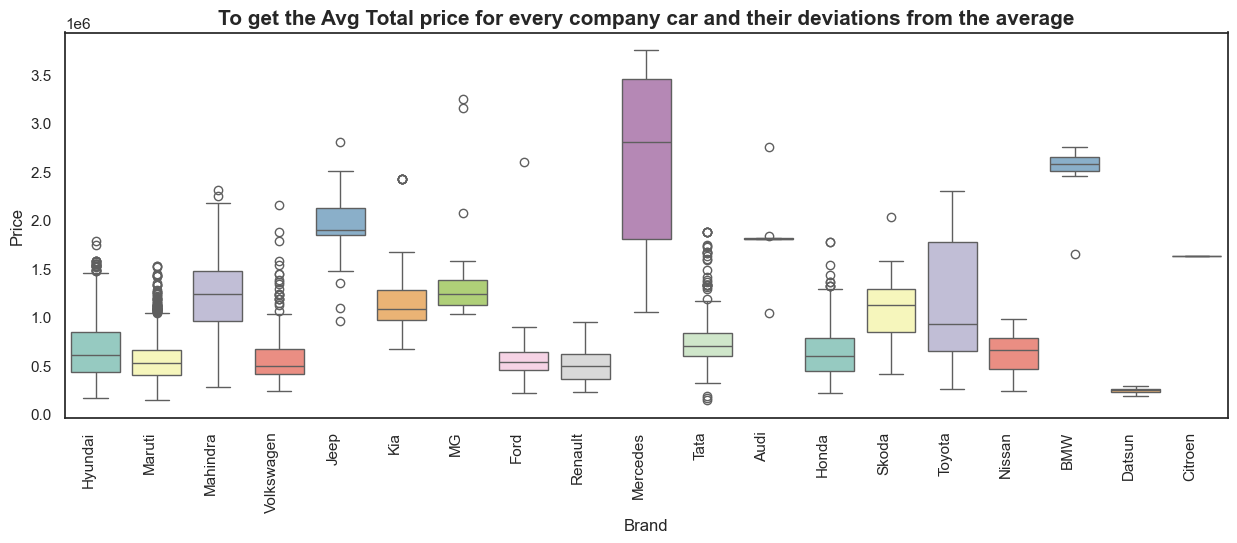

In [85]:

k=plt.figure(figsize=(15,5))
k=sns.boxplot( x=df["Brand"], y=df["Price"],hue='Brand',data=df,palette='Set3',legend=False)
y=k.set_xticklabels(k.get_xticklabels(), rotation=90, ha="right")
k=plt.title("To get the Avg Total price for every company car and their deviations from the average",fontsize=15,fontweight="bold")


C:\Users\User\AppData\Local\Temp\ipykernel_11408\3297160723.py:4: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  y=k.set_xticklabels(k.get_xticklabels(), rotation=40, ha="right")


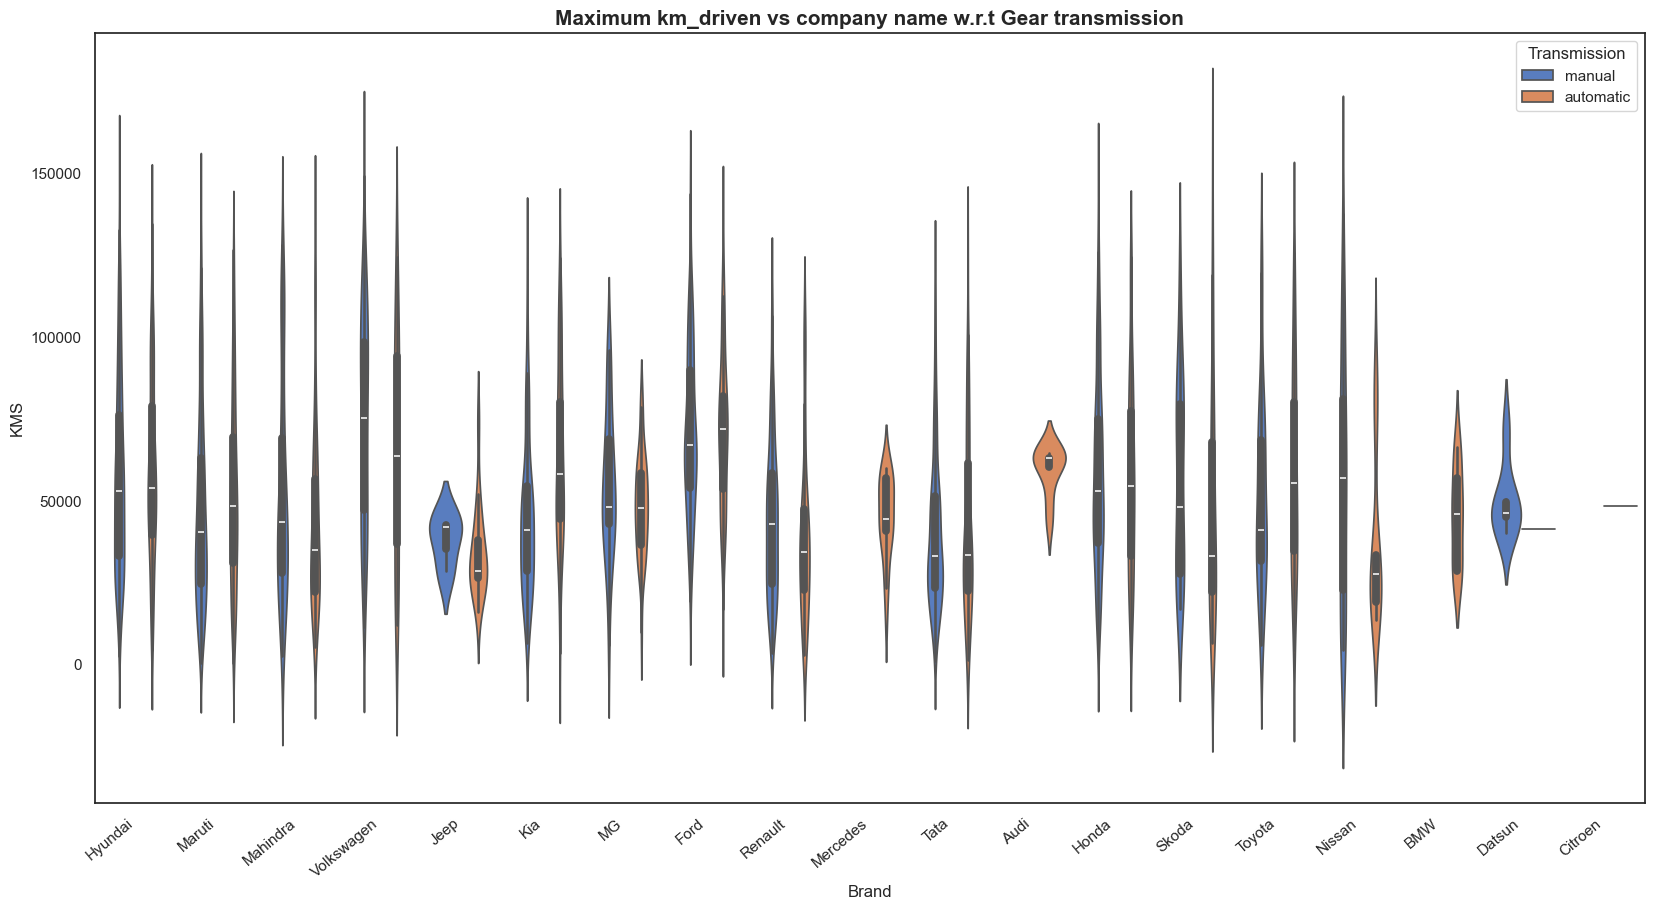

In [88]:

k=plt.figure(figsize=(20,10))
k = sns.violinplot(x="Brand", y="KMS", hue="Transmission",
                    data=df, palette="muted")
y=k.set_xticklabels(k.get_xticklabels(), rotation=40, ha="right")
k=plt.title("Maximum km_driven vs company name w.r.t Gear transmission",fontsize=15,fontweight="bold")

<Figure size 2000x700 with 0 Axes>

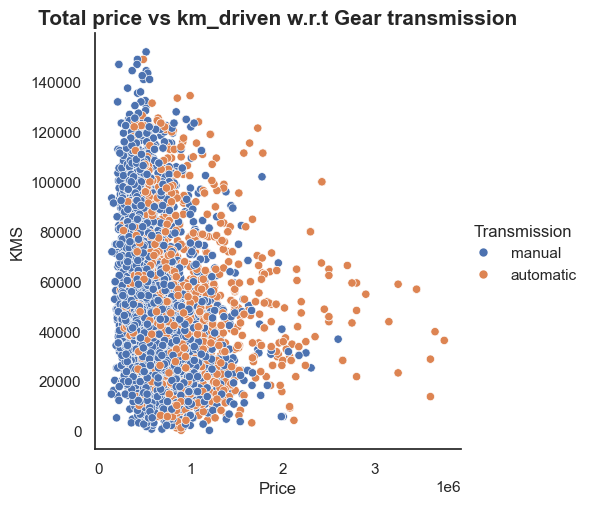

In [89]:
k=plt.figure(figsize=(20,7))
k=sns.relplot(x="Price", y="KMS", hue="Transmission", 
           data=df);
k=plt.title("Total price vs km_driven w.r.t Gear transmission",fontsize=15,fontweight="bold")



C:\Users\User\anaconda3\Lib\site-packages\seaborn\categorical.py:3399: UserWarning: 49.4% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
C:\Users\User\anaconda3\Lib\site-packages\seaborn\categorical.py:3399: UserWarning: 42.9% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
C:\Users\User\anaconda3\Lib\site-packages\seaborn\categorical.py:3399: UserWarning: 22.9% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
C:\Users\User\anaconda3\Lib\site-packages\seaborn\categorical.py:3399: UserWarning: 6.0% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
C:\Users\User\anaconda3\Lib\site-packages\seaborn\categorical.py:3399: UserWarning: 24.3% of the points canno

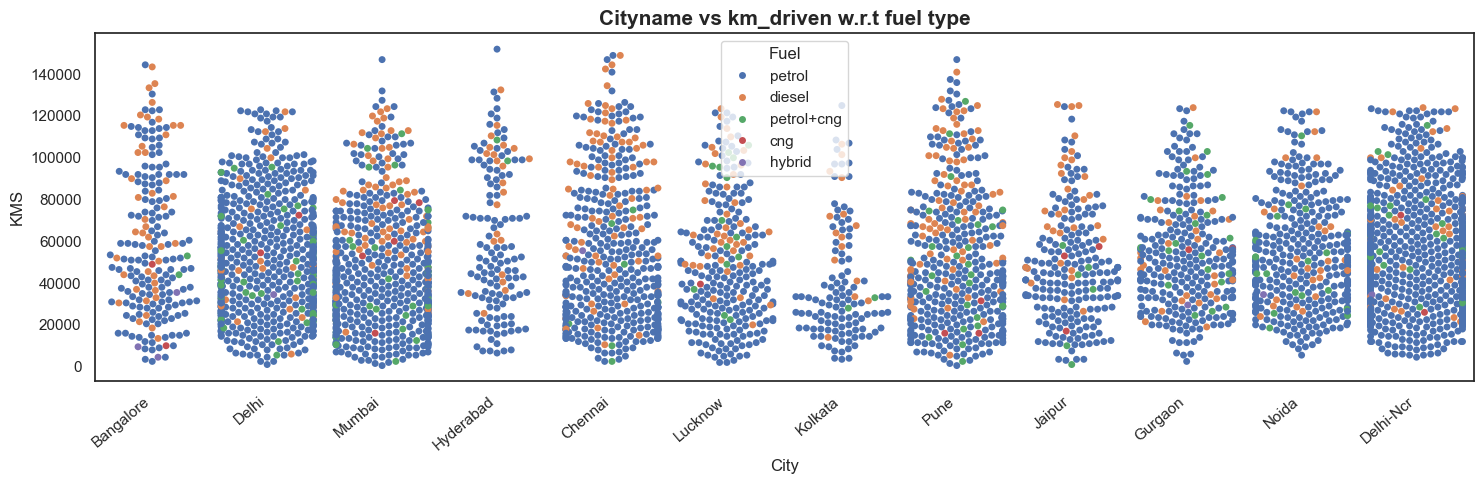

In [90]:
fig=plt.figure(figsize=(15,5))
k=sns.swarmplot(x='City',y="KMS",hue="Fuel",data=df)

y=k.set_xticklabels(k.get_xticklabels(), rotation=40, ha="right")
#ax.set_xticklabels(ax.get_xticklabels(), fontsize=7)
k=plt.title("Cityname vs km_driven w.r.t fuel type",fontsize=15,fontweight="bold")
plt.tight_layout()
plt.show(y)

In [92]:
top_10car = df.groupby("Car")['Price'].max().nlargest(10)
top10 = pd.DataFrame(top_10car)

In [96]:
top10_car = pd.merge(top10,df,on = "Price")

In [98]:
top10_car

,Price,Brand,Car,Year,City,KMS,Fuel,Transmission,Emi
0,3750000,Mercedes,E-ClassE220d Avantgarde,2018,Bangalore,36500,diesel,automatic,64496
1,3650000,Mercedes,E-ClassE200 Expression,2018,Bangalore,40000,petrol,automatic,62776
2,3600000,Mercedes,C-ClassC 200 Progressive,2021,Mumbai,14000,petrol,automatic,61916
3,3600000,Mercedes,C-ClassC 200 Progressive,2021,Pune,29000,petrol,automatic,61916
4,3250000,MG,GlosterSavvy 2.0 Twin Turbo 6 STR 4WD,2021,Bangalore,59000,diesel,automatic,55896
5,3250000,Mercedes,C-ClassC 200 Progressive,2021,Hyderabad,23500,petrol,automatic,55896
6,2900000,Mercedes,E-ClassE200 Avantgarde,2017,Mumbai,55000,petrol,automatic,49876
7,2800000,Mercedes,C-ClassC 220 CDI Progressive,2019,Mumbai,48500,diesel,automatic,48156
8,2800000,Jeep,MeridianLimited (O) 4X2 AT,2022,Mumbai,22000,diesel,automatic,48156
9,2800000,Mercedes,GLC220d Progressive,2017,Chennai,59500,diesel,automatic,48156


In [100]:
Top=df.groupby(["City"])[["Price","KMS","Brand","Car","Transmission","Fuel"]].max()
Bottom=df.groupby(["City"])[["Price","KMS","Brand","Car","Transmission","Fuel"]].min()

In [102]:
Top=pd.DataFrame(Top)

In [104]:
Top=Top.reset_index()
Top

,City,Price,KMS,Brand,Car,Transmission,Fuel
0,Bangalore,3750000,144500,Volkswagen,i20Sportz 1.2 BS-IV,manual,petrol+cng
1,Chennai,2800000,149000,Volkswagen,i20 N LineN8 1.0 Turbo DCT Dual Tone,manual,petrol+cng
2,Delhi,3450000,123000,Volkswagen,i20Sportz 1.2,manual,petrol+cng
3,Delhi-Ncr,3450000,124000,Volkswagen,i20Sportz 1.2,manual,petrol+cng
4,Gurgaon,3450000,124000,Volkswagen,i20 Active1.2 SX,manual,petrol+cng
5,Hyderabad,3250000,152000,Toyota,i20Sportz (O) 1.2 MT,manual,petrol+cng
6,Jaipur,3450000,125500,Volkswagen,i20Sportz 1.2,manual,petrol+cng
7,Kolkata,1952000,125000,Volkswagen,i20 N LineN8 1.0 Turbo DCT,manual,petrol+cng
8,Lucknow,2005000,123500,Volkswagen,i20Asta (O) 1.2 IVT,manual,petrol+cng
9,Mumbai,3600000,147000,Volkswagen,i20Asta 1.2 IVT,manual,petrol+cng


In [106]:
Bottom=pd.DataFrame(Bottom)

In [108]:
Bottom=Bottom.reset_index()
Bottom

,City,Price,KMS,Brand,Car,Transmission,Fuel
0,Bangalore,180000,2500,Audi,A-StarVxi,automatic,cng
1,Chennai,229000,2500,BMW,5 Series520d Luxury Line,automatic,diesel
2,Delhi,147000,1000,Audi,5 Series520d Luxury Line,automatic,cng
3,Delhi-Ncr,184000,4500,Audi,A-StarVXI,automatic,cng
4,Gurgaon,197000,2500,Audi,A-StarVXI,automatic,cng
5,Hyderabad,204999,6500,Datsun,Alto 800LXi,automatic,diesel
6,Jaipur,231000,1000,Audi,5 Series520d Luxury Line,automatic,cng
7,Kolkata,182000,3500,Datsun,Alto 800LXi,automatic,diesel
8,Lucknow,178000,2000,Ford,A-StarVxi,automatic,cng
9,Mumbai,196000,500,Audi,3 Series GT320d GT Sport Line,automatic,cng


In [ ]:
Top["car"]=Top["Brand"]+" "+Top["Car"]
Bottom["car"]=Bottom["Company_name"]+" "+Bottom["Vehicle_version"]